# Gaussian Mixtures

Sometimes, our data look like they are generated by a "mixture" model. What do we mean by that? In statistics land, it means we believe that there are "mixtures" of subpopulations generating the data that we observe. A common activity, then, is to estimate the subpopulation parameters.

Let's take a look at it by generating some simulated data to illustrate the point.

In [1]:
import sys
sys.executable

'/Users/maer3/anaconda/envs/bayesian/bin/python'

In [2]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/maer3/anaconda/envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We will start by first generating a mixture distribution that is composed of unit width Gaussians (i.e. $ N(\mu, 1) $) that are slightly overlapping.

$$ pop \sim GaussianMixture(\mu=[0, 3], \sigma=[1, 1]) $$

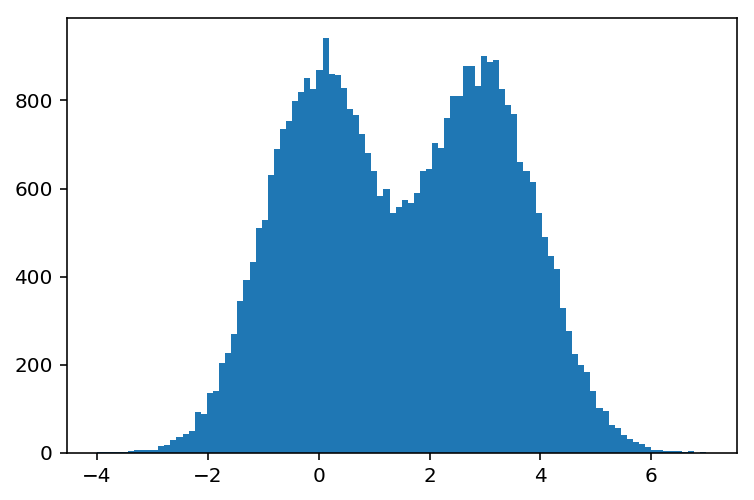

In [3]:
def generate_mixture_data(mus, sizes):
    """
    Generates mixture data
    """
    subpop1 = np.random.normal(loc=mus[0], scale=1, size=sizes[0])
    subpop2 = np.random.normal(loc=mus[1], scale=1, size=sizes[1])
    mixture = np.concatenate([subpop1, subpop2])
    return mixture

mixture = generate_mixture_data(mus=[0, 3], sizes=[20000, 20000])
plt.hist(mixture, bins=100)
plt.show()

Just to reiterate the point, one of the Gaussian distributions has a mean at 0, and the other has a mean at 3. Both subpopulations are present in equal proportions in the larger population, i.e. they have equal weighting.

Let's see if we can use PyMC3 to recover those parameters. Since we know that there are two mixture components, we can encode this in the model.

In [4]:
with pm.Model() as model:
    mu = pm.Cauchy('mu', alpha=1, beta=1, shape=(2,))
    sd = pm.HalfCauchy('sd', beta=1, shape=(2,))
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.NormalMixture('like', w=w, mu=mu, sd=sd, observed=mixture)

In [5]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/github/software/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_stickbreaking__, sd_log__, mu]
100%|██████████| 2500/2500 [02:07<00:00, 19.59it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24d6fc50>,
      dtype=object)

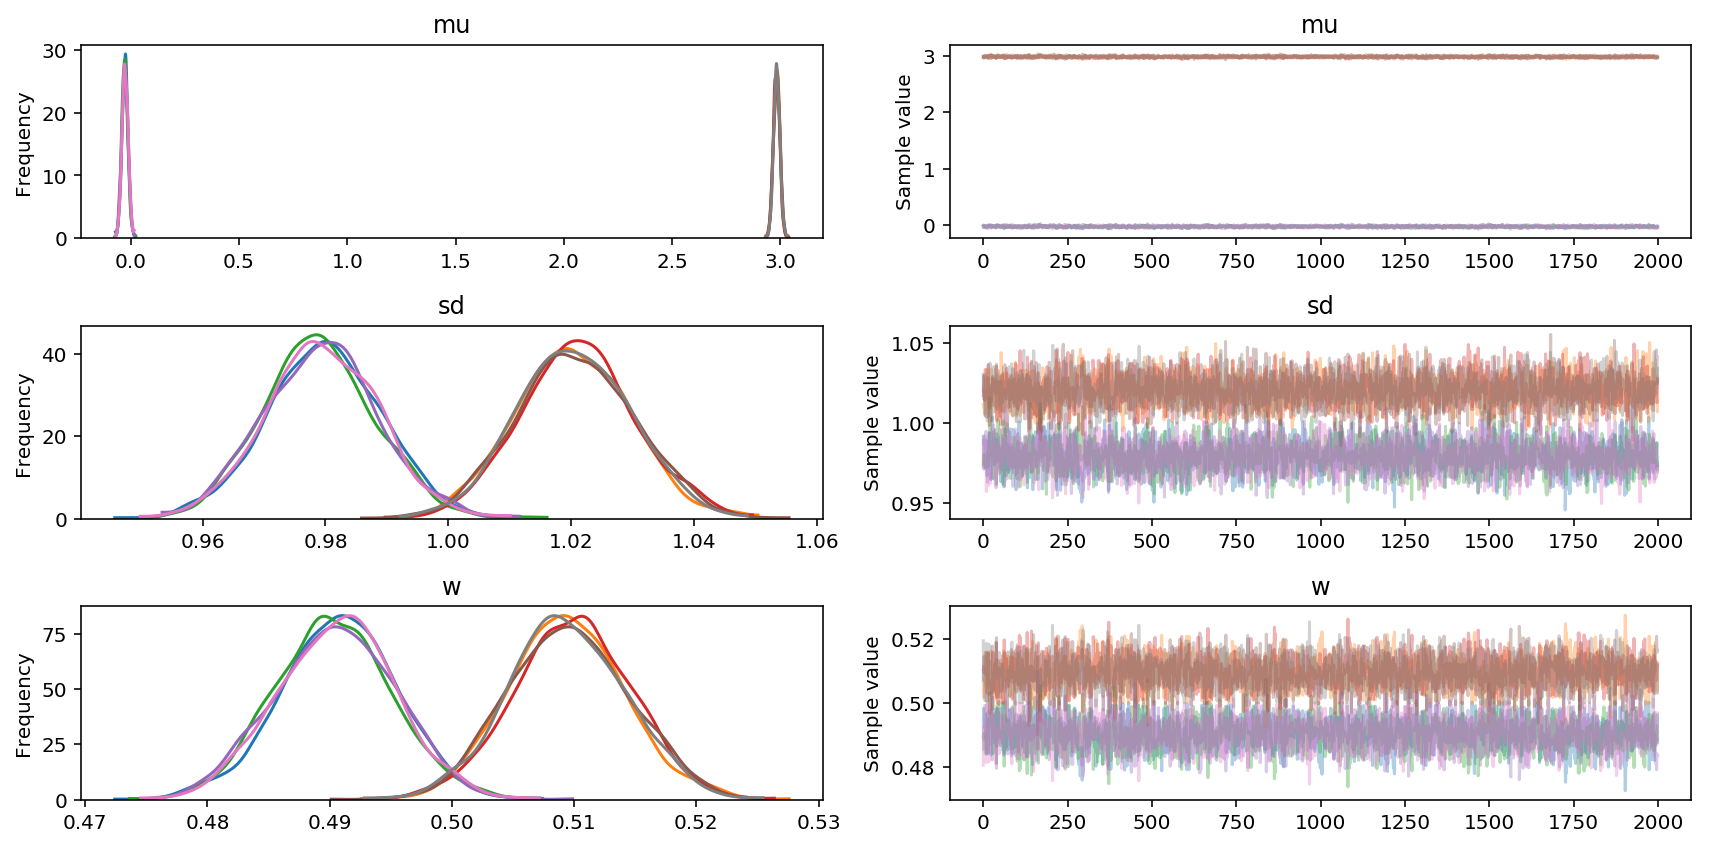

In [6]:
pm.traceplot(trace)

Now, sometimes, in our final population, one sub-population is present at a lower frequency than the other sub-population. Let's try to simulate that.

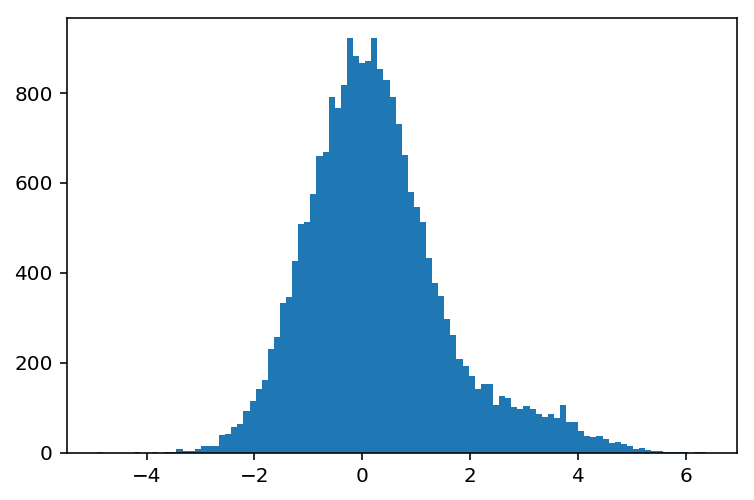

In [7]:
mixture = generate_mixture_data(mus=[0, 3], sizes=[20000, 2000])  # One is at 1/10 the size of the other.
plt.hist(mixture, bins=100)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/github/software/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_stickbreaking__, sd_log__, mu]
100%|██████████| 2500/2500 [01:11<00:00, 35.04it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


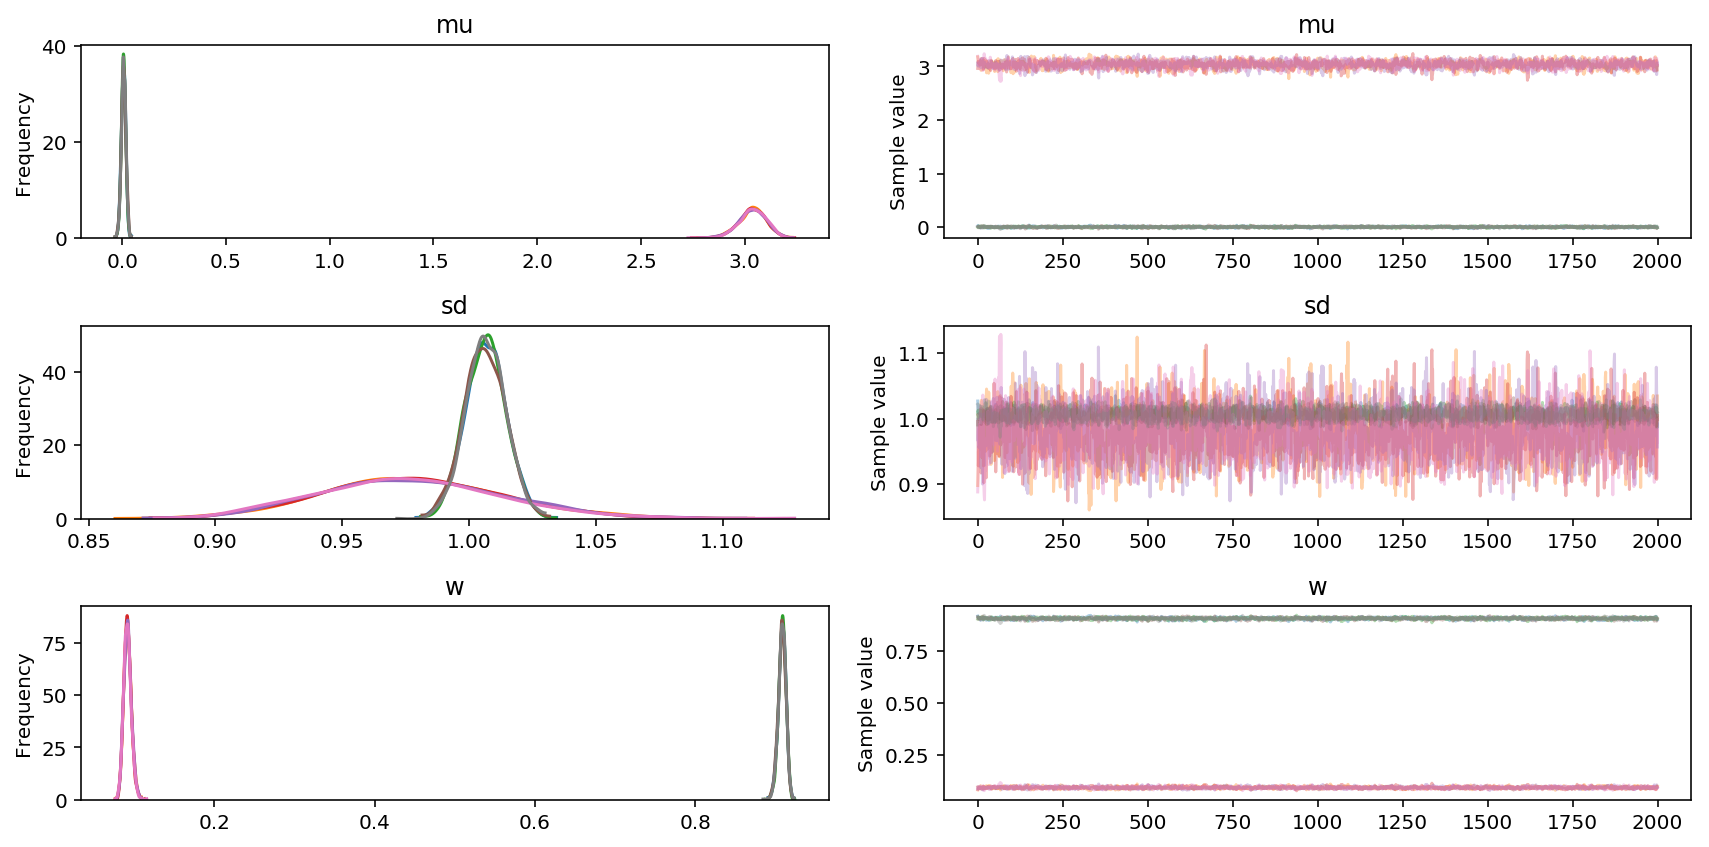

In [8]:
with pm.Model() as model:
    mu = pm.Cauchy('mu', alpha=1, beta=1, shape=(2,))
    sd = pm.HalfCauchy('sd', beta=1, shape=(2,))
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.NormalMixture('like', w=w, mu=mu, sd=sd, observed=mixture)

with model:
    trace = pm.sample(2000)
    pm.traceplot(trace)

This is really good. We have fewer samples for the group with $ \mu = 3 $, which thus means that we are much less confident about the value of $ \mu $ and $ \sigma $. What's neat is that we are nonetheless equally confident of the relative weighting of the two groups: one is much smaller in proportion than the other!

# Generalized Mixtures

We used Gaussian (a.k.a. Normal) distributions for generating the data. However, what if the data didn't come from a Gaussian distribution, but instead came from two Poissons?

In [9]:
def generate_poisson_mixtures(lams, sizes):
    grp1 = np.random.poisson(lam=lams[0], size=sizes[0])
    grp2 = np.random.poisson(lam=lams[1], size=sizes[1])
    
    mixture = np.concatenate([grp1, grp2])
    return mixture

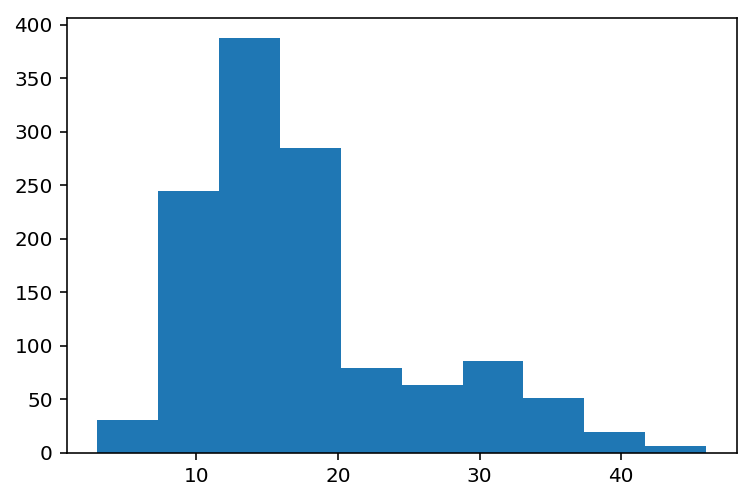

In [10]:
mixture = generate_poisson_mixtures(lams=[14, 30], sizes=[1000, 250])
plt.hist(mixture)
plt.show()

In [11]:
with pm.Model() as model:
    lam = pm.Exponential('lam', lam=1, shape=(2,))
    components = pm.Poisson.dist(mu=lam, shape=(2,))  # must use dist, not plain Poisson object!
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.Mixture('like', w=w, comp_dists=components, observed=mixture)

In [12]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/github/software/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_stickbreaking__, lam_log__]
100%|██████████| 2500/2500 [00:06<00:00, 370.07it/s]
The acceptance probability does not match the target. It is 0.8815277163760977, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8852784575666357, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameter

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20a70dd8>,
      dtype=object)

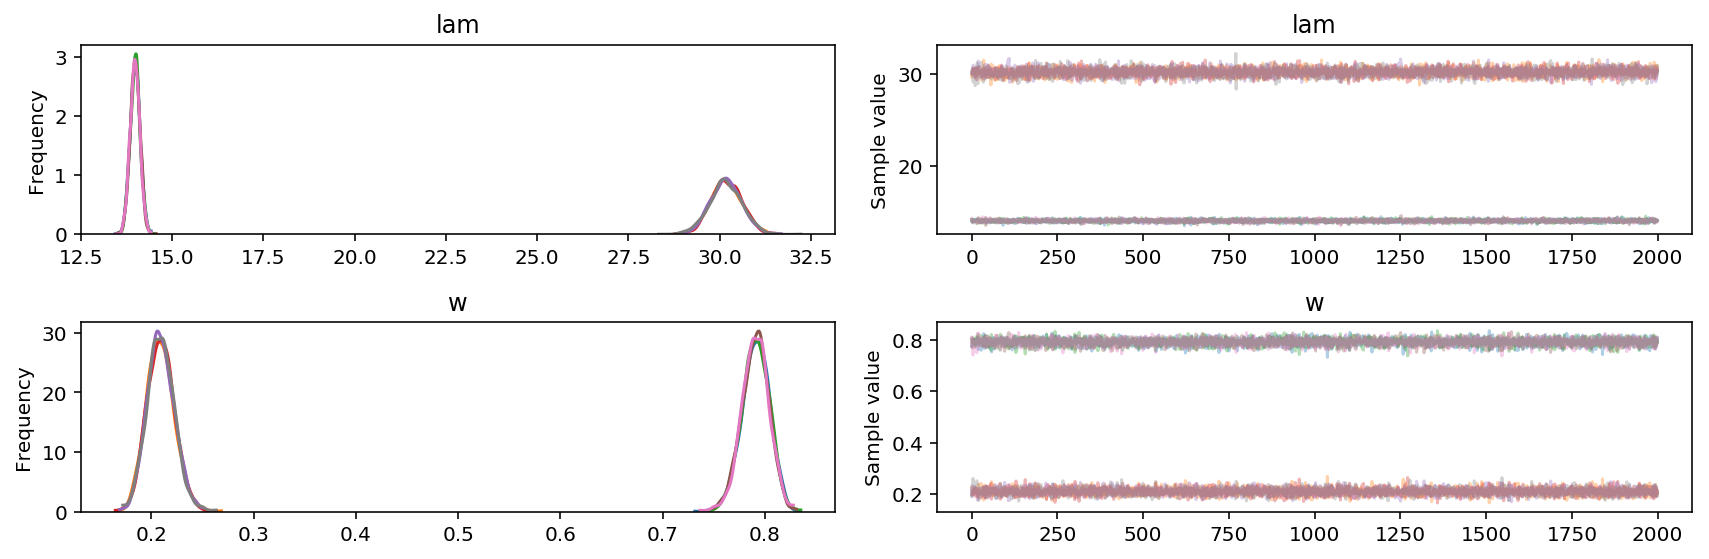

In [13]:
pm.traceplot(trace)

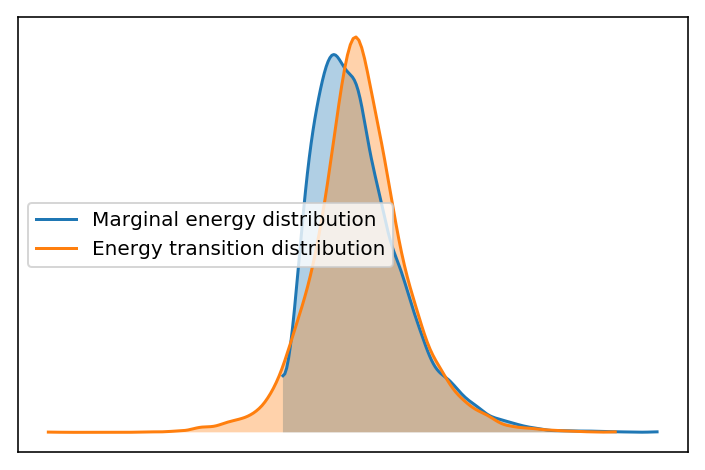

In [14]:
pm.energyplot(trace)

It worked! There was one minor detail that I had to learn from Junpeng Lao, who answered [my question](https://discourse.pymc.io/t/is-there-an-example-on-how-to-work-with-generalized-mixture-models/726) on the PyMC3 discourse site. That detail is this - that we have to use the `pm.Poisson.dist(...)` syntax, rather than `pm.Poisson(...)` syntax.

Now, what if we had much fewer data points? How would our confidence levels change?

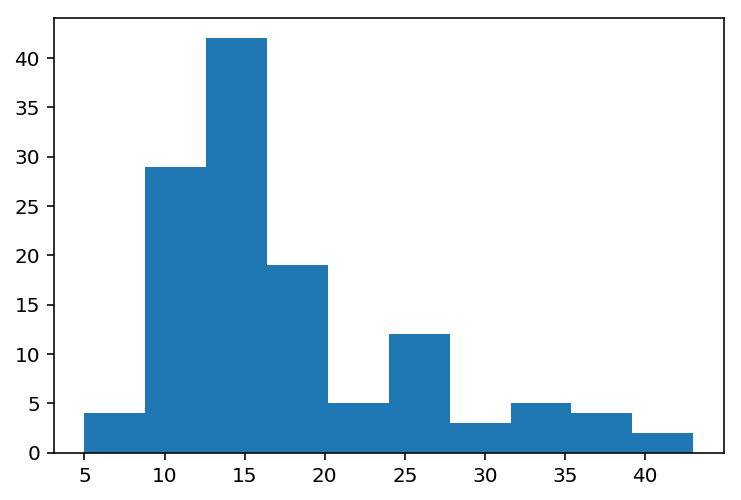

In [15]:
mixture = generate_poisson_mixtures(lams=[14, 30], sizes=[100, 25])
plt.hist(mixture)
plt.show()

In [16]:
with pm.Model() as model:
    lam = pm.Exponential('lam', lam=1, shape=(2,))
    components = pm.Poisson.dist(mu=lam, shape=(2,))  # must use dist, not plain Poisson object!
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.Mixture('like', w=w, comp_dists=components, observed=mixture)
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/github/software/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_stickbreaking__, lam_log__]
100%|██████████| 2500/2500 [00:03<00:00, 703.08it/s]
The acceptance probability does not match the target. It is 0.8829217085147464, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is small

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25fc5cc0>,
      dtype=object)

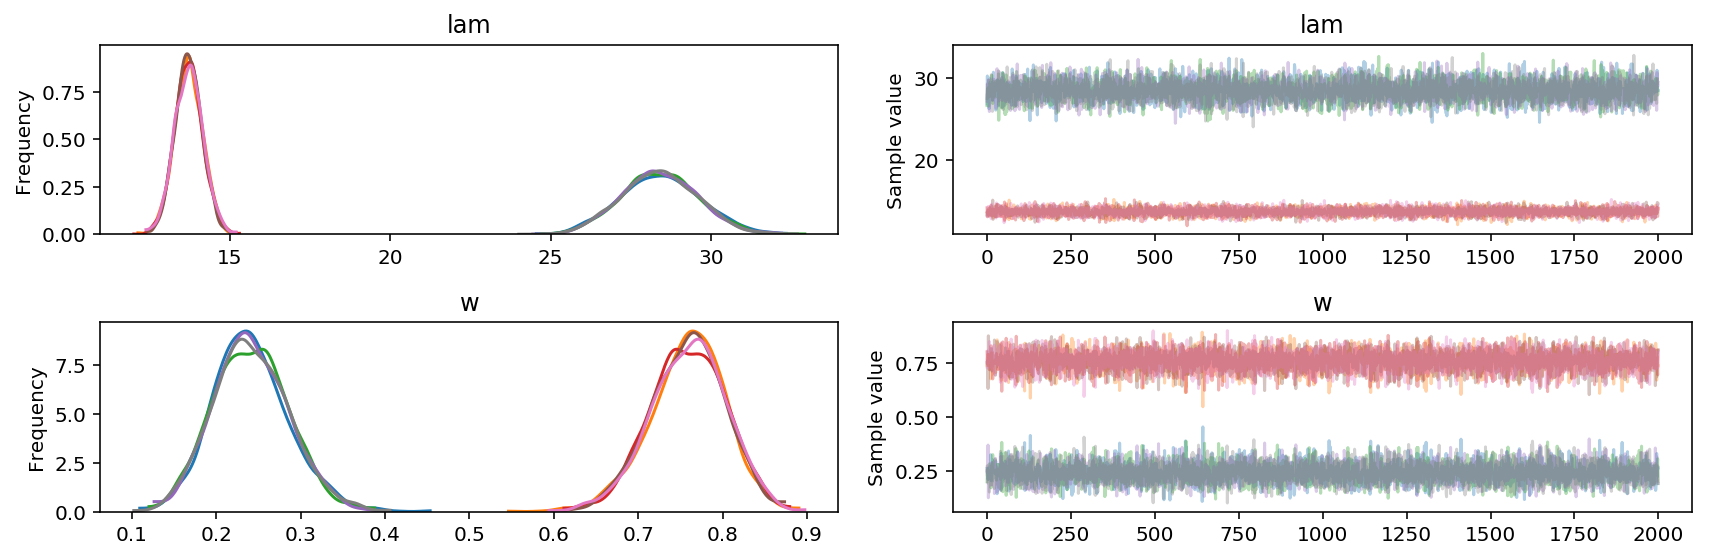

In [17]:
pm.traceplot(trace)

At ~100-ish data points, it's still not too hard to tell. What if we had fewer data points?

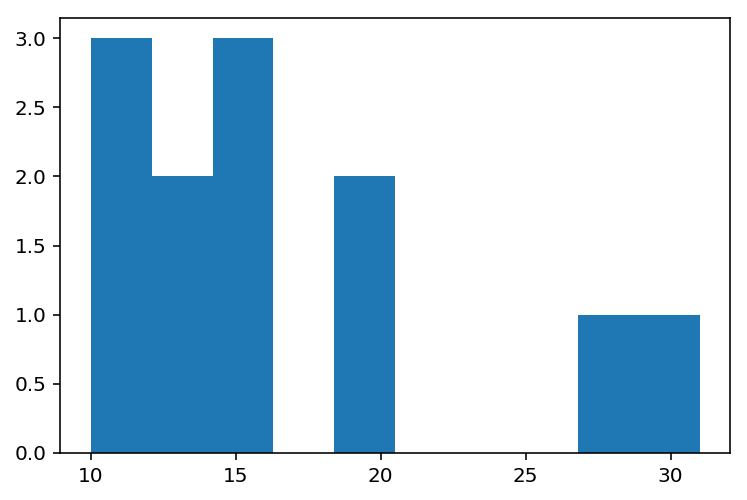

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/github/software/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_stickbreaking__, lam_log__]
100%|██████████| 2500/2500 [00:04<00:00, 613.87it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the targe

In [18]:
mixture = generate_poisson_mixtures(lams=[14, 30], sizes=[10, 2])
plt.hist(mixture)
plt.show()

with pm.Model() as model:
    lam = pm.Exponential('lam', lam=1, shape=(2,))
    components = pm.Poisson.dist(mu=lam, shape=(2,))  # must use dist, not plain Poisson object!
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.Mixture('like', w=w, comp_dists=components, observed=mixture)
    
    trace = pm.sample(2000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c316a1780>,
      dtype=object)

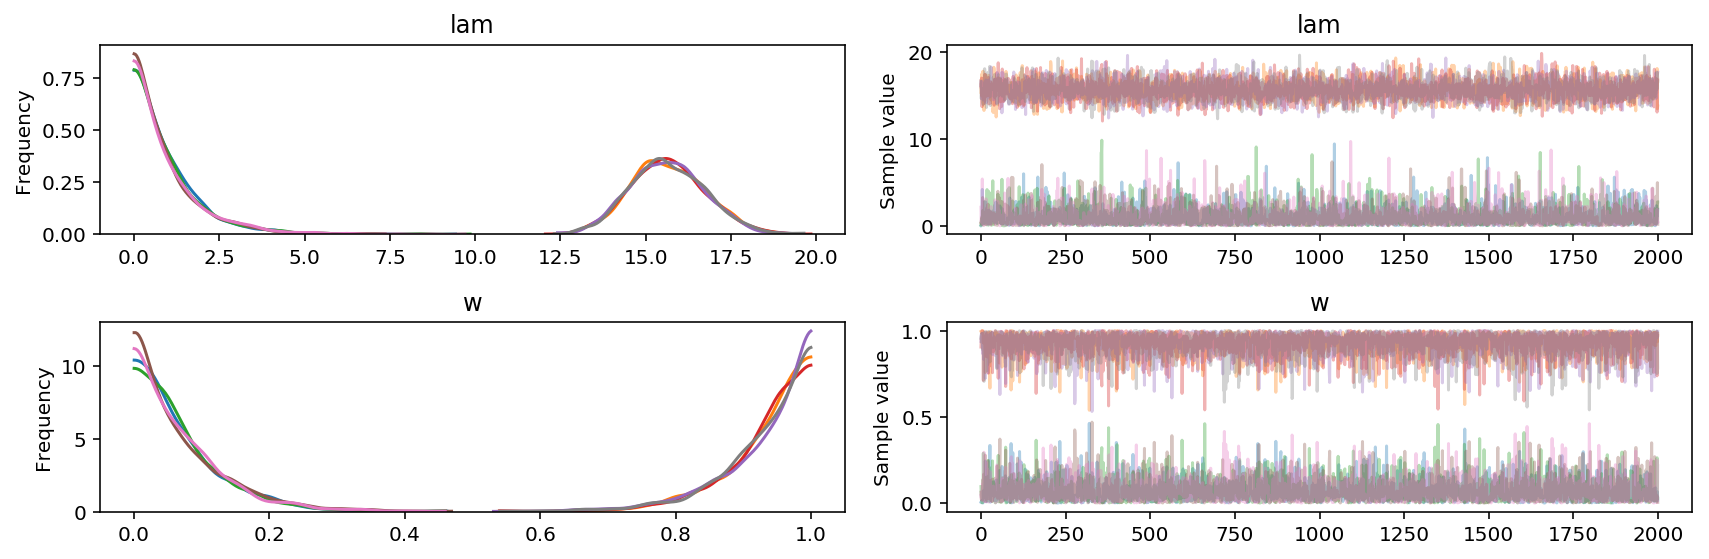

In [19]:
pm.traceplot(trace)

Model identifiability problems come in to play. `lam` parameters are very hard to estimate with little data. Moral of the story - get more data :)

Let's try **Weibull distribution mixtures**.

In [20]:
def generate_weibull_mixture(alphas, betas, size):
    
    wb1 = betas[0]*np.random.weibull(a=alphas[0], size=size)
    wb2 = betas[1]*np.random.weibull(a=alphas[1], size=size)

    mixture = np.concatenate([wb1, wb2])
    
    return mixture

(array([  111.,  2197., 11986.,  5845.,   639.,  2080.,  5279.,  7420.,
         4086.,   357.]),
 array([ 3.86380466,  5.98596091,  8.10811716, 10.23027341, 12.35242967,
        14.47458592, 16.59674217, 18.71889842, 20.84105467, 22.96321092,
        25.08536717]),
 <a list of 10 Patch objects>)

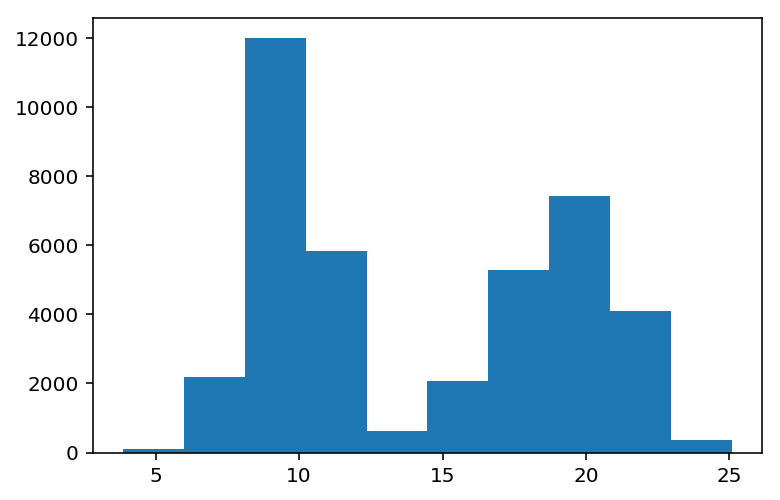

In [21]:
mixture = generate_weibull_mixture(alphas=[10, 10], betas=[20, 10], size=20000)
plt.hist(mixture)

In [22]:
with pm.Model():
    x = pm.Weibull('wb', alpha=1, beta=100).random()
    print(x)

11.414514504439213


In [40]:
with pm.Model() as model:
    # alpha1 = pm.HalfNormal('alpha1', sd=10)
    # beta1 = pm.HalfNormal('beta1', sd=10)    
    # comp1 = pm.Weibull.dist(alpha=alpha1, beta=beta1)
    
    # alpha2 = pm.HalfNormal('alpha2', sd=10)
    # beta2 = pm.HalfNormal('beta2', sd=10)    
    # comp2 = pm.Weibull.dist(alpha=alpha2, beta=beta2)
    
    alpha = pm.HalfNormal('alpha', sd=10, shape=(2,))
    beta = pm.HalfNormal('beta', sd=10, shape=(2,))
    
    components = pm.Weibull.dist(alpha=alpha, beta=beta, shape=(2,))
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))
    
    likelihood = pm.Mixture('likelihood', comp_dists=components, w=w, observed=mixture)

In [41]:
with model:
    trace = pm.sample(2000, init='advi', njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 1.2248e+05:   8%|▊         | 16891/200000 [03:06<33:43, 90.48it/s]
Convergence archived at 16900
Interrupted at 16,899 [8%]: Average Loss = 2.0262e+11
/Users/maer3/github/software/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [w_stickbreaking__, beta_log__, alpha_log__]
100%|██████████| 2500/2500 [06:06<00:00,  6.82it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3f364be0>,
      dtype=object)

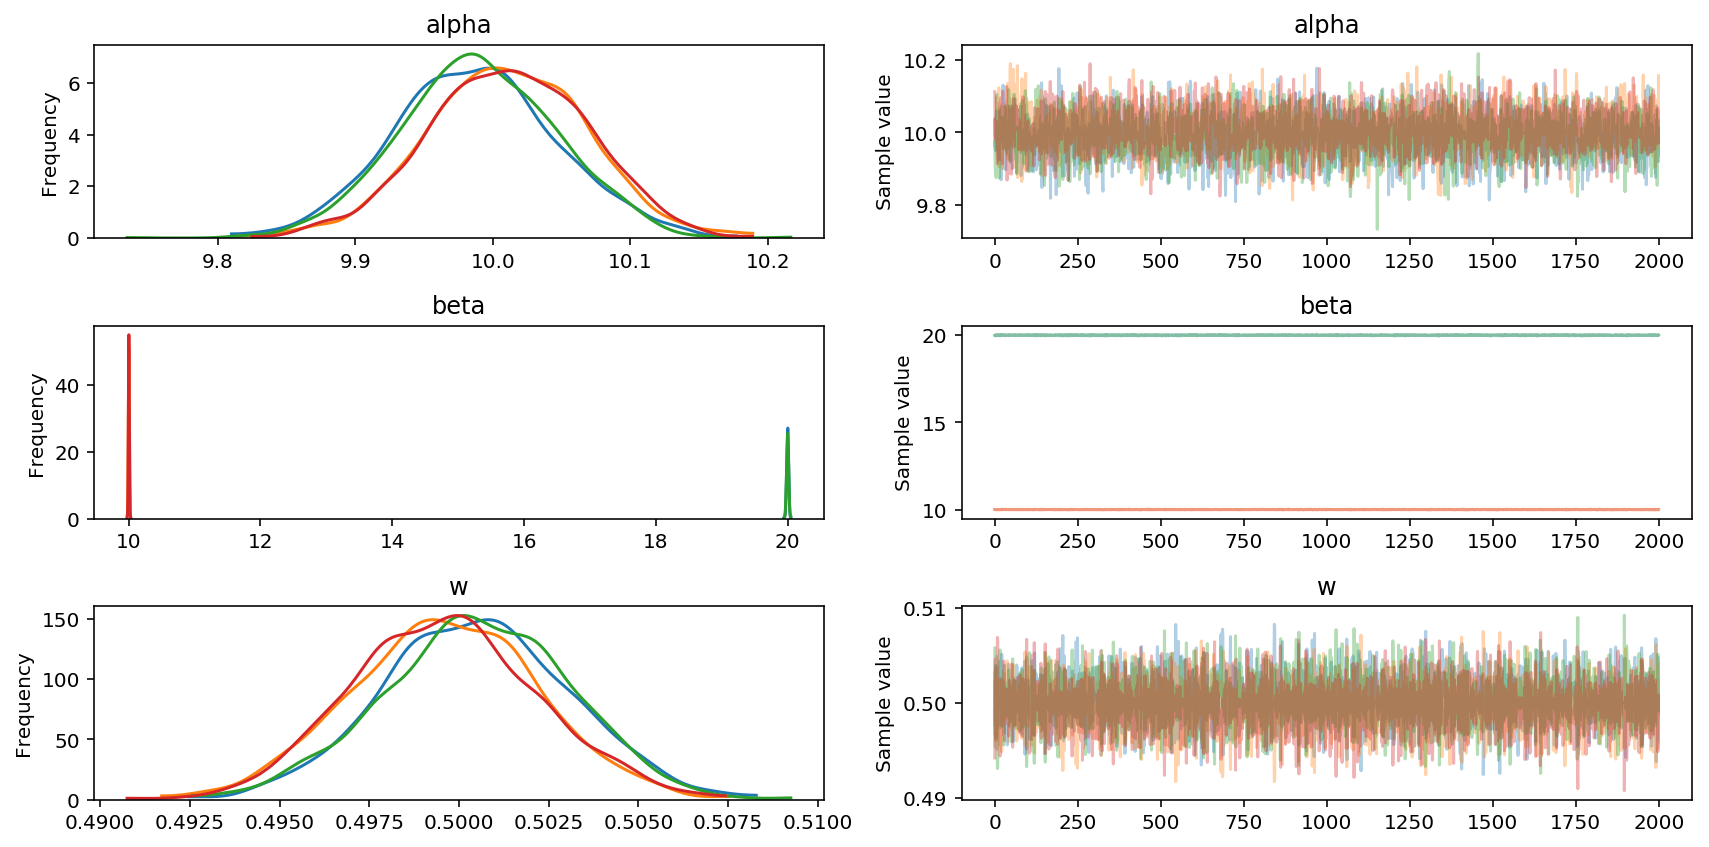

In [42]:
pm.traceplot(trace)

Parameters are recovered! It was hard-won, though; sampling takes a long time with NUTS (but we get very good samples), and I had to experiment with ADVI init vs. auto init before empirically finding out that ADVI init works better.